## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

## Hyperparameter Setting

In [3]:
CFG = {
    'WIDTH':48,
    'HEIGHT':72,
    'EPOCHS':100,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':1024,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
simulation_sem_paths = sorted(
    glob.glob('/shared/Samsung/simulation_data/SEM/*/*/*.png'))
simulation_depth_paths = sorted(glob.glob('/shared/Samsung/simulation_data/Depth/*/*/*.png') +
                                glob.glob('/shared/Samsung/simulation_data/Depth/*/*/*.png'))


In [6]:
data_len = len(simulation_sem_paths) # == len(simulation_depth_paths)

In [7]:
def data_split(train_x, train_y):
    X_train, X_valid, y_train, y_valid = train_test_split(
        train_x, train_y, test_size=0.2, shuffle=False, random_state=42)

    return X_train, X_valid, y_train, y_valid

In [8]:
train_sem_paths, val_sem_paths, train_depth_paths, val_depth_paths = data_split(
    simulation_sem_paths, simulation_depth_paths)


In [7]:
# train_sem_paths = simulation_sem_paths[:int(data_len*0.8)] # train data
# train_depth_paths = simulation_depth_paths[:int(data_len*0.8)] # gt

# val_sem_paths = simulation_sem_paths[int(data_len*0.8):]
# val_depth_paths = simulation_depth_paths[int(data_len*0.8):]

## CustomDataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, sem_path_list, depth_path_list):
        self.sem_path_list = sem_path_list
        self.depth_path_list = depth_path_list
        
    def __getitem__(self, index):
        sem_path = self.sem_path_list[index]
        sem_img = cv2.imread(sem_path, cv2.IMREAD_GRAYSCALE)
        sem_img = np.expand_dims(sem_img, axis=-1).transpose(2,0,1)
        sem_img = sem_img / 255.
        
        if self.depth_path_list is not None:
            depth_path = self.depth_path_list[index]
            depth_img = cv2.imread(depth_path, cv2.IMREAD_GRAYSCALE)
            depth_img = np.expand_dims(depth_img, axis=-1).transpose(2,0,1)
            depth_img = depth_img / 255.
            return torch.Tensor(sem_img), torch.Tensor(depth_img) # B,C,H,W
        else:
            img_name = sem_path.split('/')[-1]
            return torch.Tensor(sem_img), img_name # B,C,H,W
        
    def __len__(self):
        return len(self.sem_path_list)

In [10]:
train_dataset = CustomDataset(train_sem_paths, train_depth_paths)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=6)

val_dataset = CustomDataset(val_sem_paths, val_depth_paths)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [11]:
train_df = train_dataset
val_df = val_dataset

In [12]:
train_df[0][0].shape

torch.Size([1, 72, 48])

In [13]:
# Extract data for booster model

def extract_data(data):
    data_x = []
    data_y = []
    for i in range(len(data)):
        data_x.append(data[i][0].float().view(-1))
        data_y.append(data[i][1].float().view(-1))
    
    return data_x, data_y

In [14]:
train_x, train_y = extract_data(train_df)
val_x, val_y = extract_data(val_df)

In [134]:
type(train_x[0][0])

float

In [18]:

def lst_to_df(list):
    return pd.DataFrame(list)

In [20]:
train_x_df = lst_to_df(train_x)
train_y_df = lst_to_df(train_y)
val_x_df = lst_to_df(val_x)
val_y_df = lst_to_df(val_y)

In [88]:
print("SEM(features) 결측치 확인 :", train_df[10][0].isnan().any())
print("Depth(labels) 결측치 확인 :", train_df[0][1][0].isnan().any())

SEM(features) 결측치 확인 : tensor(False)
Depth(labels) 결측치 확인 : tensor(False)


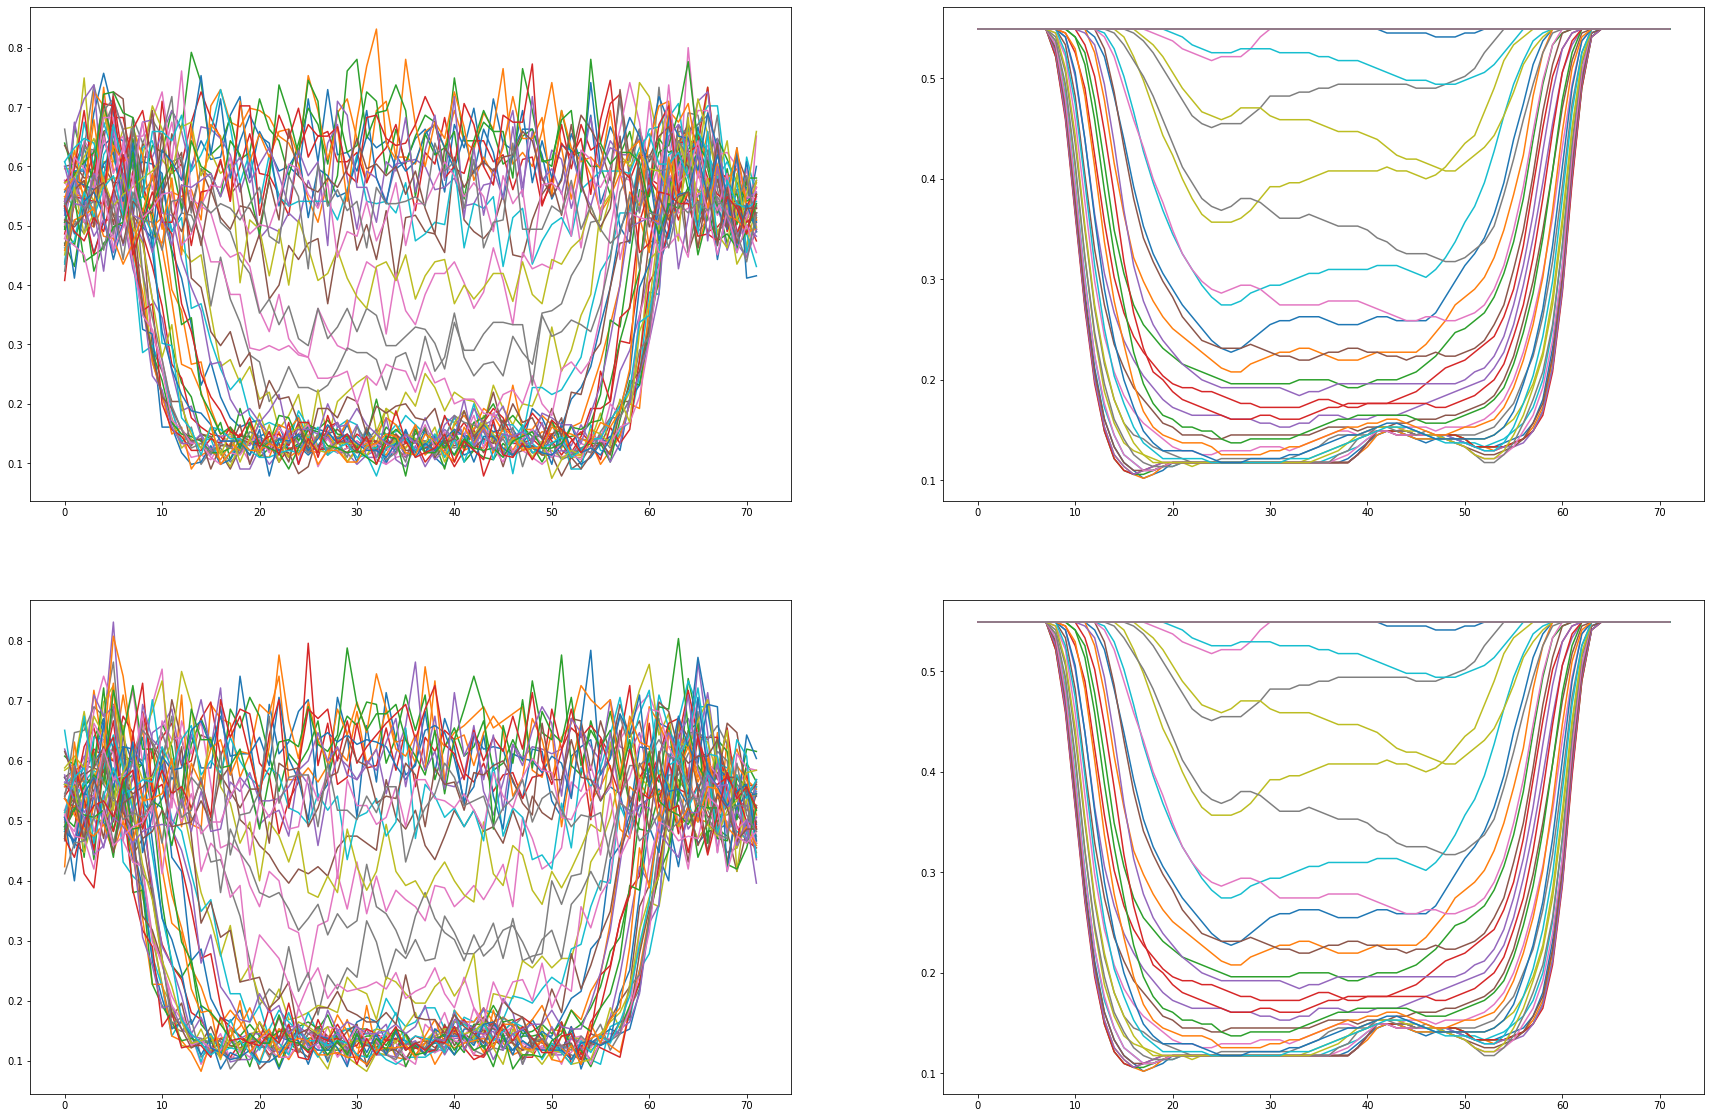

In [40]:
# 두 데이터 (SEM, Depth)의 깊이 단면 비교
plt.figure(figsize=(30,20))

plt.subplot(221)
plt.plot(train_df[0][0][0])

plt.subplot(222)
plt.plot(train_df[0][1][0])

plt.subplot(223)
plt.plot(train_df[1][0][0])

plt.subplot(224)
plt.plot(train_df[1][1][0]) 
# plt.legend()
plt.show()

## Model Define

In [15]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        # self.model = models.efficientnet_b0()

        self.encoder_1 = nn.Sequential(
            nn.Linear(CFG['HEIGHT']*CFG['WIDTH'], 1024),  # 72x48, 1024
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )

        self.middle_layer_1 = self.make_layers(512, num_repeat=100)

        self.encoder_2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )

        self.decoder_1 = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
        )

        self.decoder_2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, CFG['HEIGHT']*CFG['WIDTH']),
        )

    def make_layers(self, value, num_repeat):
        layers = []
        for _ in range(num_repeat):
            layers.append(nn.Linear(value, value))
            layers.append(nn.BatchNorm1d(value))
            layers.append(nn.LeakyReLU(inplace=False))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, CFG['HEIGHT']*CFG['WIDTH'])
        # print(x)
        # print(type(x))
        # print(x.shape)
        x = self.encoder_1(x)
        x = self.middle_layer_1(x)
        x = self.encoder_2(x)
        x = self.decoder_1(x)
        x = self.decoder_2(x)
        x = x.view(-1, 1, CFG['HEIGHT'], CFG['WIDTH'])
        return x


## Train

In [16]:
def validation(model, criterion, val_loader, device):
    model.eval()
    rmse = nn.MSELoss().to(device)

    val_loss = []
    val_rmse = []
    with torch.no_grad():
        for sem, depth in tqdm(iter(val_loader)):
            sem = sem.float().to(device)
            depth = depth.float().to(device)

            model_pred = model(sem)
            loss = criterion(model_pred, depth)

            pred = (model_pred*255.).type(torch.int8).float()
            true = (depth*255.).type(torch.int8).float()

            b_rmse = torch.sqrt(criterion(pred, true))

            val_loss.append(loss.item())
            val_rmse.append(b_rmse.item())

    return np.mean(val_loss), np.mean(val_rmse)


In [17]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.L1Loss().to(device)
    best_score = 999999
    best_model = None

    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for sem, depth in tqdm(iter(train_loader)):
            sem = sem.float().to(device)
            depth = depth.float().to(device)

            optimizer.zero_grad()
            # print("SEM SHAPE", sem.shape)
            # print("SEM", sem)
            model_pred = model(sem)
            # print("PRED SHAPE", model_pred.shape)
            # print("PRED", model_pred)
            loss = criterion(model_pred, depth)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        val_loss, val_rmse = validation(model, criterion, val_loader, device)
        print(
            f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val RMSE : [{val_rmse:.5f}]')

        if best_score > val_rmse:
            best_score = val_rmse
            best_model = model

        if scheduler is not None:
            scheduler.step()

    return best_model


## Run!!

In [82]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [18]:
model = BaseModel()
model.eval()

optimizer = torch.optim.Adam(
    params=model.parameters(), lr=CFG["LEARNING_RATE"])
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer, T_max=len(train_loader)*CFG['EPOCHS'], eta_min=0)
scheduler = None

infer_model = train(model, optimizer, train_loader,
                    val_loader, scheduler, device)


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [1] Train Loss : [0.06349] Val Loss : [0.10319] Val RMSE : [6.28555]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [2] Train Loss : [0.04877] Val Loss : [0.07894] Val RMSE : [5.53599]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [3] Train Loss : [0.04680] Val Loss : [0.12133] Val RMSE : [11.10614]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [4] Train Loss : [0.04110] Val Loss : [0.06200] Val RMSE : [4.73142]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [5] Train Loss : [0.03750] Val Loss : [0.05502] Val RMSE : [4.51117]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [6] Train Loss : [0.03331] Val Loss : [0.06588] Val RMSE : [4.79851]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [7] Train Loss : [0.03210] Val Loss : [0.05378] Val RMSE : [4.37571]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [8] Train Loss : [0.03163] Val Loss : [0.06449] Val RMSE : [4.86664]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [9] Train Loss : [0.03064] Val Loss : [0.06594] Val RMSE : [4.95990]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [10] Train Loss : [0.03038] Val Loss : [0.04951] Val RMSE : [4.20382]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [11] Train Loss : [0.02989] Val Loss : [0.06108] Val RMSE : [4.63299]


  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch : [12] Train Loss : [0.02981] Val Loss : [0.05036] Val RMSE : [4.22595]


  0%|          | 0/136 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Inference & Submission

In [16]:
test_sem_path_list = sorted(glob.glob('//shared/Samsung/test/SEM/*.png'))

In [17]:
test_dataset = CustomDataset(test_sem_path_list, None)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=6)

In [18]:
import zipfile
def inference(model, test_loader, device):
    model.to(device)
    model.eval()
    
    result_name_list = []
    result_list = []
    with torch.no_grad():
        for sem, name in tqdm(iter(test_loader)):
            sem = sem.float().to(device)
            model_pred = model(sem)
            
            for pred, img_name in zip(model_pred, name):
                pred = pred.cpu().numpy().transpose(1,2,0)*255.
                save_img_path = f'{img_name}'
                #cv2.imwrite(save_img_path, pred)
                result_name_list.append(save_img_path)
                result_list.append(pred)
    
    os.makedirs('./submission', exist_ok=True)
    os.chdir("./submission/")
    sub_imgs = []
    for path, pred_img in zip(result_name_list, result_list):
        cv2.imwrite(path, pred_img)
        sub_imgs.append(path)
    submission = zipfile.ZipFile("../submission.zip", 'w')
    for path in sub_imgs:
        submission.write(path)
    submission.close()

In [19]:
inference(infer_model, test_loader, device)

100%|██████████| 51/51 [00:09<00:00,  5.15it/s]
